## Flow Model

Any generative model especially in the image space are considered as transport problem. U will start from one distribution (usually random or uniform) and move to another distribution (data distribution). The reason for doing this is that we don't know data distribution and only have i.i.d samples (aka data), also the data distribution is often complex and difficult to sample from. SDE, DDPM, Normalizing flows, continous flows, GANs and VAEs are some of these approaches. 

while training any generative models, we would like to have some nice properties. 
- Generate high quality images/videos. 
- Optimal cost of inference. 
- Deterministic. 

To our advantage, there is one paper which explains us how to do this [Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow](https://arxiv.org/pdf/2209.03003)

## Pre-requsites
- Ordinary Differential equations
- ODE solvers.


Flow is designed as an optimal transport problem. we transport images from one distribution $\pi_{0}$ (noise) to another distribution $\pi_{1}$ (data distribution). the following are the set of equations defined in the paper.

$$
x_{t} = tx_{1}+(1-t)x_{0} \tag{1}
$$

$$
\frac{dx_{t}}{dt} = x_{1} - x_{0} \tag{2}
$$

the goal of the neural network is to learn the above differential equation. we sample t and find x_{t} using eq(1) and then we will pass x_{t} and t to the neural network T(x_t, t) and get an output. 

the optimization problem is to solve 

$$
\int_{0}^{t} ||(x_{1} - x_{0}) - (T(x_{t}, t))||^{2}_{2} \tag{2}
$$

How do we sample t? we know that t should be between 0-1, so we can use any distribution which samples and produces numbers within this range. so we can use simple uniform distribution or logit normal distribution (this is from another paper, which experimented with different distribution and found this to work better). we will discuss more about this later

## Psuedo algorithm while training
- take a batch of images $x_{1}$
- sample noise $x_{0}$
- sample a t for each image. use $x_{1}$, $x_{0}$ and $t$ to produce $x_{t}$
- use neural network T($x_{t}$, t) to process the inputs.
- calculate mean squared error as given in eq(3)
- repeat the process.

this is it, the model is trained and evaluated in the entire ambient space. think of Neural network is in y axis and t is in x axis, we know the gradient (direction) at each and every point. 

## Inference.
since we know the starting point ($x_{0}$), and direction is given by the neural network at the point, we can use euler's method to transport this noise and generate an image. 

$$
x_{t} = x_{t-1}+ \nabla_{t} f(x_{t-1}, t-1) 
$$

if we use t = 0.1 as step size, then we find the images as $x_{0.1}$, $x_{0.2}$, $x_{0.3}$, ... $x_{1}$. this took 10 evaluation steps. if we use a step size of 0.01, we use 100 steps.

we can also use advanced numerical solvers like  RK2 .. RK5 to solve the ODE and generate new samples. we will see with code below on how to do this. 


Fundamentally this is what flow means. Simple and Clean

## Some interesting properties mentioned in the paper
- Flow path don't cross each other (aka non-crossing property). In the ambient space, if u take any point we get only one gradient, if a crossing is present, at that point, we need to have two different values for $dx_{t}/dt$ which is not possible in ODE setting. so if you sample 10 points from $\pi_{0}$ traverse the path to $\pi_{1}$ u will see that none of them meet at any point. 
- the probability is preserved throughout the flow. Law($X_{t}$) = Law($Z_{t}$). Here $z_{t}$ is model output and $X_{t}$ is obtained using linear equation described here
- Reducing transport costs. the cost of transporting $z_{0}$ to $z_{1}$ is always lower than cost of transporting $x_{0}$ to $x_{1}$ no matter whatever cost function u use. this allows us to not worry about the cost function.
- Reflow, straightening and fast simulation. if we train a new model on $z_{0}$ to $z_{1}$ then it is called reflow-1, if we again train on reflow-1 outputs, it is called reflow-2. As more reflow's occur the paths become more straight which allows to simulate fast during inference. 
- when doing image to image translation, it is better to add a small noise to inputs as this will lead to a smooth input variable. 

In [1]:
# Looad required libraries 

import torch 
import numpy as np
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
# Now say we have MNIST data in the shape of (N, 1, 28, 28)
# we will create a VAE model to generate new images similar to the training data. 

# Load MNIST data 

# Load MNIST data and resize it to 64x64
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=128, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=128, shuffle=False)

len(train_loader), len(val_loader)

(469, 79)

In [3]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

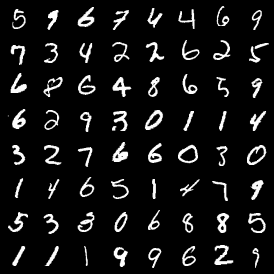

In [4]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs[:64], nrow=8, normalize=False))

# first lets train using linear flow 

In [5]:
time = torch.distributions.Uniform(0, 1)
time.sample((10,))

tensor([0.8332, 0.7516, 0.6095, 0.6528, 0.1852, 0.0316, 0.0829, 0.5174, 0.9264,
        0.6555])

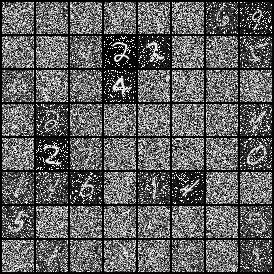

In [ ]:
# eq = xt = tx1 + (1-t)x0 where x0 is pure noise and x1 is the original name 
bs = imgs.shape[0]
t = time.sample((bs,)).unsqueeze(1).unsqueeze(1).unsqueeze(1)
noise = torch.randn_like(imgs)
xt = t*(2*imgs-1) + (1-t)*noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((xt[:64]+1)/2, nrow=8, normalize=False))

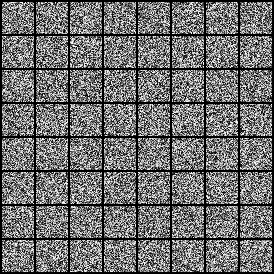

In [7]:
target = (2*imgs-1) - noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(target[:64], nrow=8, normalize=False))

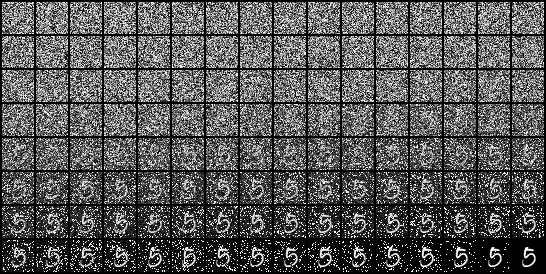

In [8]:
# lets also look how same image looks at different timesteps
simgs = imgs[0].unsqueeze(0).repeat(128, 1, 1, 1)
bs = simgs.shape[0]
t = torch.linspace(0, 1, bs).unsqueeze(1).unsqueeze(1).unsqueeze(1)
noise = torch.randn_like(simgs)
sxt = (t)*(2*simgs-1) + (1-t)*noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((sxt+1)/2, nrow=16, normalize=False))

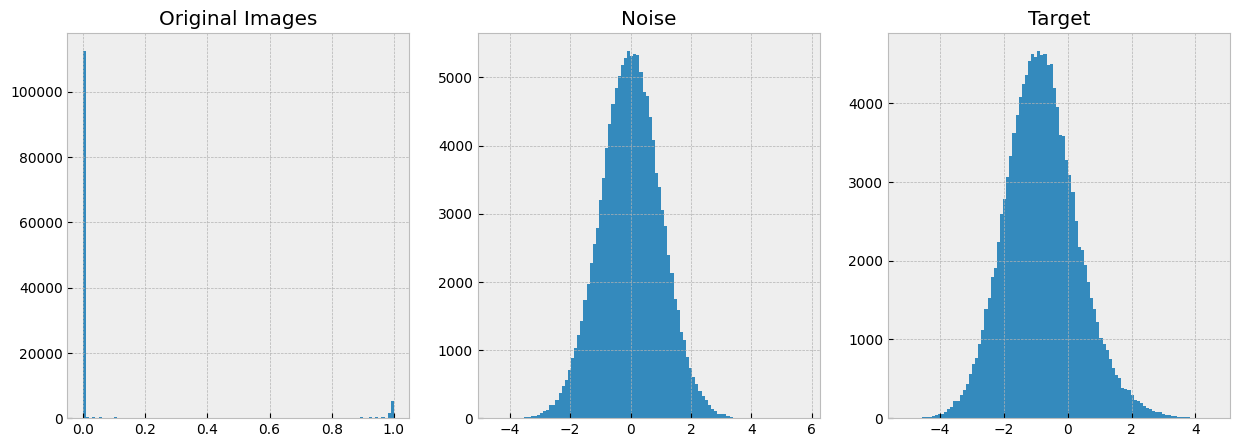

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(imgs.view(-1).numpy(), bins=100)
ax[0].set_title('Original Images')
ax[1].hist(noise.view(-1).numpy(), bins=100)
ax[1].set_title('Noise')
ax[2].hist(target.view(-1).numpy(), bins=100)
ax[2].set_title('Target')
plt.show()

## network

In [ ]:
from diffusers import UNet2DModel

device = "cuda"

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
)
model.to(device)
print("model loaded")

/home/prakashjay/genai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model loaded


In [11]:
count = 0
for name, param in model.named_parameters():
    count += param.numel()
count # this is a ~16 million parameters model


35741697

In [12]:
out = model(xt.to(device), t.flatten(0).to(device))
out.sample.shape, torch.nn.functional.mse_loss(out.sample, target.to(device))

(torch.Size([128, 1, 32, 32]),
 tensor(2.1450, device='cuda:0', grad_fn=<MseLossBackward0>))

In [13]:
def sample_images(model, n_samples, device):
    model.eval()
    time_steps = torch.linspace(0, 1, 50).to(device)
    final_images = torch.zeros(n_samples, 50, 1, 32, 32, device=device)
    noise = torch.randn((n_samples, 1, 32, 32), device=device)
    for i, t in tqdm(enumerate(time_steps)):
        #x_{t} = x_{t-1}+f(x_{t-1}, t-1) 
        if i == 0:
            xt = noise 
            final_images[:, i, ...] = noise 
        else:
            dt = time_steps[i] - time_steps[i-1]
            with torch.no_grad():
                xt = final_images[:, i-1, ...] + dt * model(final_images[:, i-1, ...], time_steps[i-1].repeat(n_samples))["sample"]
        final_images[:, i, ...] = xt.detach()
        #print(f"sampled {i} images")
    return final_images

In [14]:
final_images = sample_images(model, 32, device)

14it [00:00, 70.70it/s]

50it [00:00, 75.40it/s]


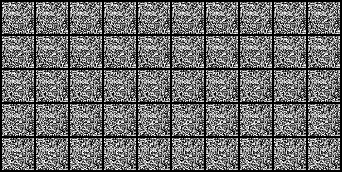

In [15]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((final_images[0]+1)/2, nrow=10, normalize=False))

> train the model 

In [16]:
# we will add EMA weights to the model. 
import copy

def exists(val):
    return val is not None

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
    def update_average(self, old, new):
        if not exists(old):
            return new
        return old * self.beta + (1 - self.beta) * new

ema = EMA(beta=0.9999)
ema_model = copy.deepcopy(model)

In [17]:
epochs = 100 
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
total_steps = len(train_loader) * epochs
tdist = torch.distributions.Uniform(0, 1)

iter = 0 
train_loss = []

for epoch in range(epochs):
    model.train()
    epoch_loss = []
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            optimizer.zero_grad()
            
            x1, _ = batch
            x1 = 2*x1.to(device) - 1
            noise = torch.randn((x1.shape[0], 1, 32, 32), device=device)
            t = tdist.sample((x1.shape[0],)).unsqueeze(1).unsqueeze(1).unsqueeze(1).to(device)
            xt = t*x1 + (1-t)*noise
            target = x1 - noise 
            model_output = model(xt.to(device), t.flatten(0).to(device))["sample"]
            
            loss = torch.nn.functional.mse_loss(model_output, target.to(device))
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Add gradient clipping
            optimizer.step()

            #calculate loss 
            tepoch.set_postfix(loss=loss.item())
            epoch_loss.append(loss.item())
                    
            #update ema model 
            for current_params, ma_params in zip(model.parameters(), ema_model.parameters()):
                    old_weight, up_weight = ma_params.data, current_params.data
                    ma_params.data = ema.update_average(old_weight, up_weight)
    
    train_loss.extend(epoch_loss)
    store = {
         "ema_model": ema_model.state_dict(),
         "model": model.state_dict(),
         "train_loss": np.mean(epoch_loss)
    }
    torch.save(store, f"generated/ema_model_{epoch}_{np.mean(epoch_loss):3f}.pth")
    print(f"Epoch {epoch} completed: train loss {np.mean(epoch_loss)}")
    #TODO: calculate some metric between generated images and original images

    ema_model.eval()
    out= sample_images(ema_model, 4, device)
    out = (out+1)/2
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out[0].cpu(), nrow=10, normalize=True))
    img.save(f"generated/generated_images_{epoch}.png")
        

In [64]:
# model.load_state_dict(torch.load("generated/ema_model_99_0.125880.pth", map_location=device, weights_only=False)["model"])
# print("model loaded")

model loaded


50it [00:00, 81.72it/s]


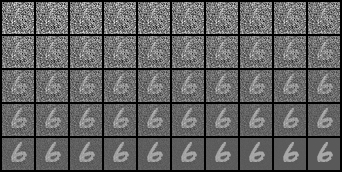

In [65]:
model.eval()
out = sample_images(model, 64, device)
out = (out+1)/2
img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out[0].cpu(), nrow=10, normalize=True))
img

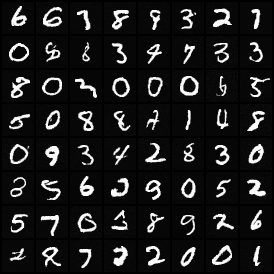

In [66]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out[:, -1, ...].clamp(-1, 1).cpu(), nrow=8, normalize=True))

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(train_loss[10:])
plt.title("Training Loss")
plt.show()

##  reverse flow is possible. 


we should be able to go back to noise and then flow back again to the same image.

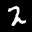

In [69]:
torchvision.transforms.ToPILImage()(imgs[12])

In [70]:
x1 = imgs[12].unsqueeze(0)
x1 = 2*x1-1
time_steps = torch.linspace(1, 0, 50)
x1.shape, time_steps.shape, x1.max(), x1.min()

(torch.Size([1, 1, 32, 32]), torch.Size([50]), tensor(1.), tensor(-1.))

In [71]:
outs = []
for i, t in tqdm(enumerate(time_steps)):
    if i == 0:
        xt = x1
    else:
        dt = time_steps[i-1] - time_steps[i]
        with torch.no_grad():
            out = model(xt.cuda(), t.repeat(1).cuda())["sample"].detach().cpu()
        xt = xt - dt*out
    outs.append(xt.squeeze(0))

outs = torch.stack(outs)
outs.shape

50it [00:00, 81.96it/s]


torch.Size([50, 1, 32, 32])

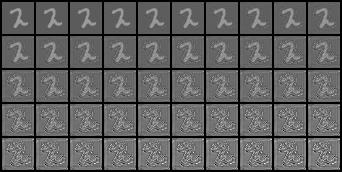

In [72]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(outs, nrow=10, normalize=True))

> Lets plot a histogram and see how distribution changed from image space to noise.

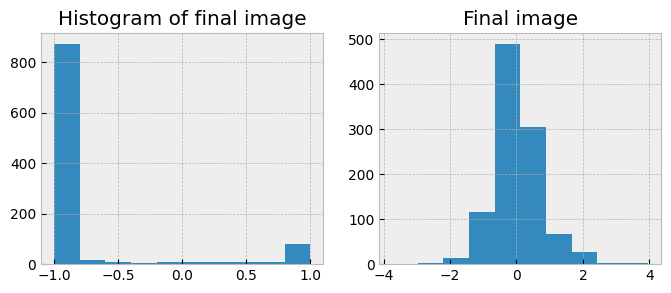

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(outs[0].flatten().cpu().numpy())
ax[0].set_title("Histogram of final image")
ax[1].hist(outs[-1].flatten().cpu().numpy())
ax[1].set_title("Final image")
plt.show()

> reconstruct from noise. 

In [76]:
noise = outs[-1].unsqueeze(0)
time_steps = torch.linspace(0, 1, 50)
outs_forward = []
for i, t in tqdm(enumerate(time_steps)):
    if i == 0:
        xt = noise
    else:
        dt = time_steps[i] - time_steps[i-1]
        with torch.no_grad():
            xt = xt + dt*model(xt.cuda(), t.repeat(1).cuda())["sample"].detach().cpu()
    outs_forward.append(xt.squeeze(0))
outs_forward = torch.stack(outs_forward)
outs_forward.shape

50it [00:00, 81.40it/s]


torch.Size([50, 1, 32, 32])

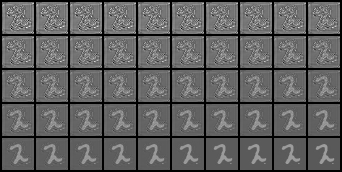

In [77]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(outs_forward, nrow=10, normalize=True))

## FID scores
Lets generate some 10k images and calculate FID scores. 

In [78]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(feature=2048).cuda()

for n, ds in enumerate(val_loader):
    x1, _ = ds
    x1 = 2*x1.to(device) - 1
    generated_images = sample_images(ema_model, x1.shape[0], device)
    generated_images = generated_images[:, -1, ...].clamp(-1, 1)
    generated_images = torch.concat([generated_images, generated_images, generated_images], axis=1) 
    x1 = torch.concat([x1, x1, x1], axis=1)
    fid.update((255*(generated_images+1)/2).to(torch.uint8), real=False)
    fid.update((255*(x1+1)/2).to(torch.uint8), real=True)
fid_score = fid.compute()
fid_score




50it [00:00, 76.11it/s]
50it [00:00, 76.22it/s]
50it [00:00, 76.22it/s]
50it [00:00, 76.24it/s]
50it [00:00, 76.26it/s]
50it [00:00, 76.30it/s]
50it [00:00, 76.26it/s]
50it [00:00, 76.31it/s]
50it [00:00, 76.29it/s]
50it [00:00, 76.24it/s]
50it [00:00, 76.23it/s]
50it [00:00, 76.23it/s]
50it [00:00, 76.27it/s]
50it [00:00, 76.28it/s]
50it [00:00, 76.28it/s]
50it [00:00, 76.30it/s]
50it [00:00, 76.29it/s]
50it [00:00, 76.24it/s]
50it [00:00, 76.24it/s]
50it [00:00, 76.24it/s]
50it [00:00, 76.27it/s]
50it [00:00, 76.29it/s]
50it [00:00, 76.27it/s]
50it [00:00, 76.31it/s]
50it [00:00, 76.19it/s]
50it [00:00, 76.25it/s]
50it [00:00, 76.23it/s]
50it [00:00, 76.24it/s]
50it [00:00, 76.25it/s]
50it [00:00, 76.30it/s]
50it [00:00, 76.28it/s]
50it [00:00, 76.29it/s]
50it [00:00, 76.28it/s]
50it [00:00, 76.23it/s]
50it [00:00, 76.25it/s]
50it [00:00, 76.25it/s]
50it [00:00, 76.30it/s]
50it [00:00, 76.33it/s]
50it [00:00, 76.35it/s]
50it [00:00, 76.31it/s]
50it [00:00, 76.36it/s]
50it [00:00, 76.

tensor(72.5247, device='cuda:0')

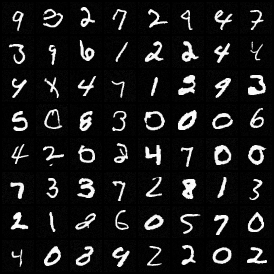

In [62]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(generated_images[:64], nrow=8, normalize=True))

> though visually the images look very nice, the fid score is really high

TODO: check why fid scores are high

## Now lets see if ODE solvers can be used to generate samples. 

this allow us to see if we can further reduce the number of evaluation steps.

In [79]:
def flow_ode(t, x, model):
    """
    Define the ODE for the flow model
    dx/dt = model(x, t)
    """
    batch_size = x.shape[0]
    t = t.repeat(batch_size)
    return model(x, t)["sample"]

In [82]:
from torchdiffeq import odeint

def sample_images_rk45(model, n_samples, device, rtol=1e-5, atol=1e-5):
    model.eval()
    
    # Initial condition (noise)
    x0 = torch.randn((n_samples, 1, 32, 32), device=device)
    
    # Time points to evaluate
    t = torch.linspace(0, 1, 10).to(device)  # start and end points
    
    # Solve ODE
    with torch.no_grad():
        solution = odeint(
            lambda t, x: flow_ode(t, x, model),
            x0,
            t,
            method='dopri5',  # RK45
            rtol=rtol,
            atol=atol
        )
    
    return solution[-1]  # Return final state

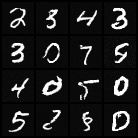

In [85]:
generated_images = sample_images_rk45(model, 16, device)
generated_images = (generated_images+1)/2
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(generated_images.clamp(-1, 1).cpu(), nrow=4, normalize=True))
